In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# import adastra

In [31]:
%load_ext autoreload
%autoreload 1
%aimport adastra

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
fa17missing = [
    ('OIE1000', 5/3),  # OIE
    ('ENGR3590', 10/3),  # CompRobo
    ('AHSE1148', 10/3),  # DIRT TO SHIRT
    ('ENGR3590', 3),  # ADE
    ('ENGR3240', 16/3),  # TELL THE STORY
    ('MTH2132', 10/3),  # BAYESIAN
    ('AHSE1100', 10/3),  # HISTECH
    ('ENGR3299', 8),  # RETURN DESIGN
]
sp18missing = [
    ('ENGR3299', 10/3),  # BIOMIMICRY
    ('ENGR3599A', 10/3),  # HTL
    ('ENGR3299B', 8),  # RETURN DESIGN
]
tup_to_dict = lambda a: [{'Course/Customer': code, 'Weekly Length': pd.to_timedelta(hours, unit='h')} for code, hours in a]
fa17missing, sp18missing = tuple(tup_to_dict(l) for l in [fa17missing, sp18missing])

In [33]:
fa17courses = adastra.load_schedule_file('data/ad astra test fa17.xls')
sp18courses = adastra.load_schedule_file('data/ad astra test sp18.xls')

WARNING *** file size (190919) not 512 + multiple of sector size (512)
WARNING *** file size (222207) not 512 + multiple of sector size (512)


In [34]:
add_missing = lambda a, m: pd.concat([a, pd.DataFrame(m)], sort=True, ignore_index=False).reset_index()
fa17courses = add_missing(fa17courses, fa17missing)
sp18courses = add_missing(sp18courses, sp18missing)
fa17courses[-10:]

,index,Activity Type,Building,Campus,Contact/Instructor,Course/Customer,Days,End Date,End Time,Enroll,Length,Room,Section,Start Date,Start Time,Status,Subj/Reservation,Title,Weekly Length
64,560,Section,AC,Olin,"Hill, Benjamin Thomas",ENGR1125,R,2017-12-08,15:10:00,24.0,02:10:00,428,03,2017-08-31,13:00:00,Scheduled,ENGR,"Introduction to Sensors,",02:10:00
65,561,Section,AC,Olin,"Hill, Benjamin Thomas",ENGR1125,F,2017-12-08,15:10:00,24.0,02:10:00,428,04,2017-08-31,13:00:00,Scheduled,ENGR,"Introduction to Sensors,",02:10:00
66,0,NaN,NaN,NaN,NaN,OIE1000,NaN,NaT,NaT,NaN,NaT,NaN,NaN,NaT,NaT,NaN,NaN,NaN,01:40:00.000001
67,1,NaN,NaN,NaN,NaN,ENGR3590,NaN,NaT,NaT,NaN,NaT,NaN,NaN,NaT,NaT,NaN,NaN,NaN,03:19:59.999998
68,2,NaN,NaN,NaN,NaN,AHSE1148,NaN,NaT,NaT,NaN,NaT,NaN,NaN,NaT,NaT,NaN,NaN,NaN,03:19:59.999998
69,3,NaN,NaN,NaN,NaN,ENGR3590,NaN,NaT,NaT,NaN,NaT,NaN,NaN,NaT,NaT,NaN,NaN,NaN,03:00:00
70,4,NaN,NaN,NaN,NaN,ENGR3240,NaN,NaT,NaT,NaN,NaT,NaN,NaN,NaT,NaT,NaN,NaN,NaN,05:19:59.999998
71,5,NaN,NaN,NaN,NaN,MTH2132,NaN,NaT,NaT,NaN,NaT,NaN,NaN,NaT,NaT,NaN,NaN,NaN,03:19:59.999998
72,6,NaN,NaN,NaN,NaN,AHSE1100,NaN,NaT,NaT,NaN,NaT,NaN,NaN,NaT,NaT,NaN,NaN,NaN,03:19:59.999998
73,7,NaN,NaN,NaN,NaN,ENGR3299,NaN,NaT,NaT,NaN,NaT,NaN,NaN,NaT,NaT,NaN,NaN,NaN,08:00:00


In [35]:
fa17cat = pd.read_csv('Class and Room Categorization - Classes Fall 2017.csv', usecols=range(13))
fa17cat.drop_duplicates(subset='Course Code', inplace=True)
sp18cat = pd.read_csv('Class and Room Categorization - Classes Spring 2018.csv', usecols=range(13))
sp18cat.drop_duplicates(subset='Course Code', inplace=True)

In [36]:
category_colors = {  # map for category colors
    'PROJECT - BASED - 3d': '#1155cc',
    'PROJECT - BASED - 2d': '#3c78d8',
    'PROJECT - BASED - digital': '#6d9eeb',
    'LECTURE': '#e69138',
    'LAB': '#38761d',
    'NOT IN AC': '#cc0000',
    'DISCUSSION': '#674ea7'
}

category_names = {  # map for category names
    'PROJECT - BASED - 3d': 'project-based 3d',
    'PROJECT - BASED - 2d': 'project-based 2d',
    'PROJECT - BASED - digital': 'project-based digital',
    'LECTURE': '"lecture"',
    'LAB': 'lab',
    'DISCUSSION': 'discussion'
}

def merge(sched, cat, sched_code='Course/Customer', cat_code='Course Code'):

#     def agg_time(frame, group_col, agg_col):
#         return frame.groupby(group_col, as_index=False)[agg_col].agg(np.sum)

    return pd.merge(
        left=sched,
        right=cat,
        how='left',
        left_on=sched_code,
        right_on=cat_code,
        indicator=True,
#         validate='one_to_many'
    )

agg_by_time = lambda a: a.groupby('Course/Customer', as_index=False)['Weekly Length'].agg(np.sum)

def plot_pie_cat_totals(courses, group_col='Primary Category', agg_col='Weekly Length', fig=None):
    cat_totals = courses.groupby(group_col, as_index=False)[agg_col].agg(np.sum)
#     cat_totals.sort_values('Weekly Length', inplace=True)  # sort by value
    cat_totals.sort_values('Primary Category', inplace=True)  # sort by label
    
    # fig = plt.figure()
    return adastra.plot_pie(
        cat_totals[agg_col] / pd.Timedelta(1,unit='h'),
        labels=[category_names.get(category, category) for category in cat_totals[group_col]],
        colors=[category_colors.get(category, 'grey') for category in cat_totals[group_col]],
        fig=fig
        )

## Plot pie charts of courses per semester

In [37]:
cat_cols = ['Course Code','Course Title','Primary Category','Seconday Category']
fa17footprint, sp18footprint = tuple(merge(agg_by_time(sched), cat[cat_cols]) for sched, cat in [(fa17courses, fa17cat),(sp18courses, sp18cat)])

Check for missed courses

In [38]:
fa17footprint[fa17footprint['_merge'] == 'right_only']

,Course/Customer,Weekly Length,Course Code,Course Title,Primary Category,Seconday Category,_merge


In [39]:
sp18footprint[sp18footprint['_merge'] == 'right_only']

,Course/Customer,Weekly Length,Course Code,Course Title,Primary Category,Seconday Category,_merge


### Space Usage

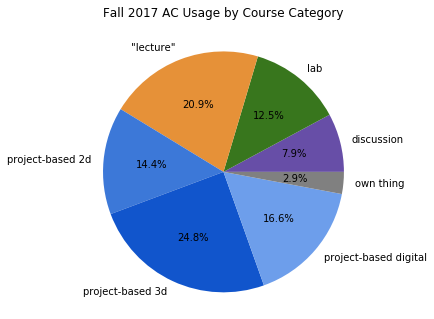

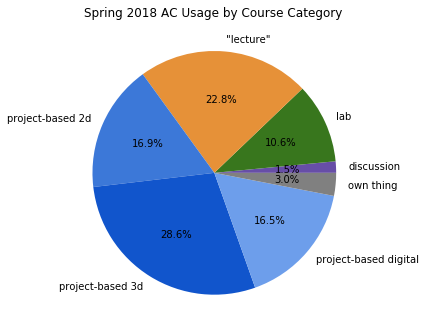

In [40]:
footprints = [
    ('Fall 2017', fa17footprint),
    ('Spring 2018', sp18footprint)
]
for name, data in footprints:
    fig = plt.figure(figsize=(7,5))
    plt.title(name+' AC Usage by Course Category', y=1.05)
    plot_pie_cat_totals(data[data['Primary Category'] != 'NOT IN AC'], fig=fig)
    plt.savefig('figs/'+name.lower().strip(' ')+'_footprint'+'.eps')

### Course Offerings

In [41]:
agg_by_course = lambda a: a.groupby('Primary Category', as_index=False)['Course/Customer'].agg('count')
agg_by_course(fa17footprint)

,Primary Category,Course/Customer
0,DISCUSSION,5
1,LAB,4
2,LECTURE,13
3,NOT IN AC,1
4,PROJECT - BASED - 2d,8
5,PROJECT - BASED - 3d,8
6,PROJECT - BASED - digital,4
7,own thing,1


In [42]:
agg_by_course(sp18footprint)

,Primary Category,Course/Customer
0,DISCUSSION,1
1,LAB,3
2,LECTURE,13
3,NOT IN AC,1
4,PROJECT - BASED - 2d,4
5,PROJECT - BASED - 3d,12
6,PROJECT - BASED - digital,5
7,own thing,2


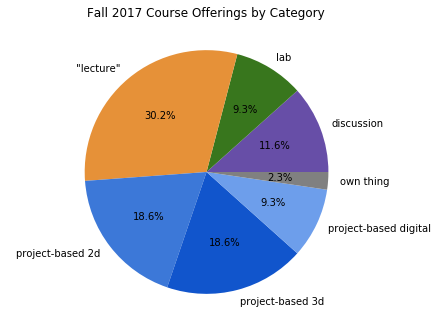

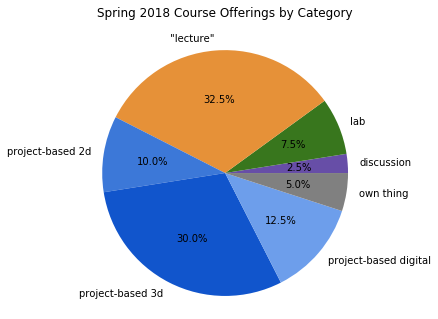

In [43]:
for name, data in footprints:
    fig = plt.figure(figsize=(7,5))
    plt.title(name+' Course Offerings by Category', y=1.05)
    cat_totals = agg_by_course(data[data['Primary Category'] != 'NOT IN AC'])
    
    adastra.plot_pie(
        cat_totals['Course/Customer'],
        labels=[category_names.get(category, category) for category in cat_totals['Primary Category']],
        colors=[category_colors.get(category, 'grey') for category in cat_totals['Primary Category']],
        fig=fig
    )
    plt.savefig('figs/'+name.lower().strip(' ')+'_offerings'+'.eps')

## Plot bar charts of courses per semester

In [44]:
import re

/home/newsch/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


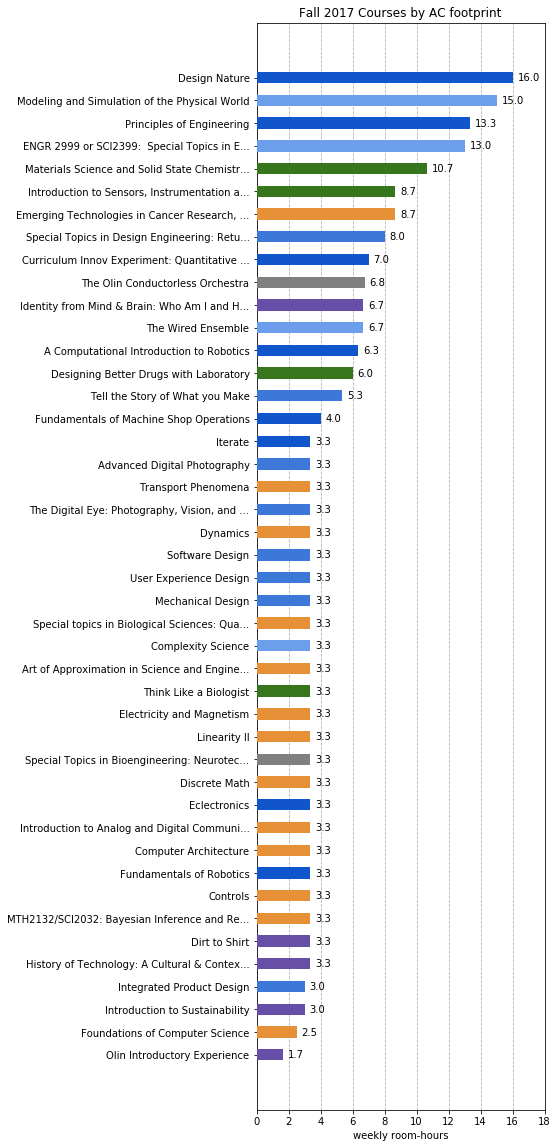

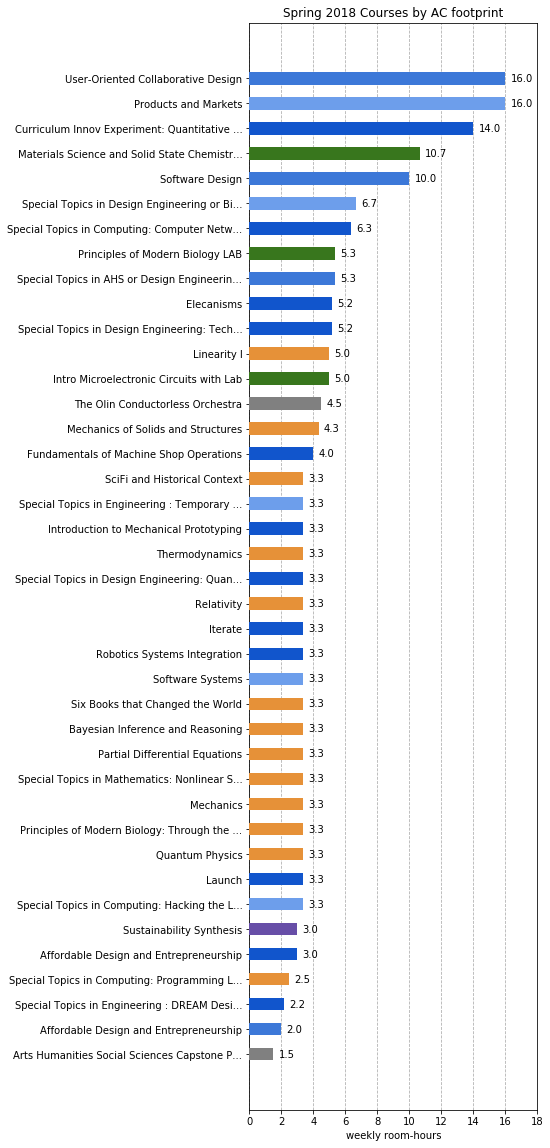

In [46]:
def plot_courses_bar(courses):
    def format_titles(titles):
        # parse out course title
        extractor = re.compile('^(?:(\w{3,4} ?\d{0,5}\w?)[:|/] )?(.*)$')
        just_titles = [extractor.match(a).group(2) for a in titles]
        # trim length of strings
        max_len = 45
        abbr_titles=[a[:max_len-3]+'...' if len(a) > max_len else a for a in just_titles]
        return abbr_titles
        
    return adastra.plot_barh(
        labels=format_titles(courses['Course Title'].astype(str)),
        values=courses['Weekly Length'] / pd.Timedelta(1, unit='h'),
        color=[category_colors.get(category, 'grey') for category in courses['Primary Category']],
        fig = plt.figure(figsize=(10,20))
    )

for name, data in footprints:
    fig = plot_courses_bar(data[data['Primary Category'] != 'NOT IN AC'][pd.notnull(data['Course Title'])].sort_values('Weekly Length'))
    plt.xlim([0,18])
    plt.title(name+' Courses by AC footprint')
    plt.xlabel('weekly room-hours')
    fig.subplots_adjust(left=0.5)  # make room for the course labels
    plt.savefig('figs/'+name.lower().strip(' ')+'_courses_footprint'+'.eps')

In [49]:
sp18courses[sp18courses['Course/Customer'] == 'ENGR2510']

,index,Activity Type,Building,Campus,Contact/Instructor,Course/Customer,Days,End Date,End Time,Enroll,Length,Room,Section,Start Date,Start Time,Status,Subj/Reservation,Title,Weekly Length
18,226,Section,AC,Olin,"Millner, Amon",ENGR2510,TF,2018-05-03,15:10:00,36.0,01:40:00,304,02,2018-01-23,13:30:00,Scheduled,ENGR,Software Design,03:20:00
33,389,Section,AC,Olin,"Millner, Amon",ENGR2510,TF,2018-05-03,15:10:00,36.0,01:40:00,326,01,2018-01-23,13:30:00,Scheduled,ENGR,Software Design,03:20:00
39,452,Section,AC,Olin,"Millner, Amon",ENGR2510,TF,2018-05-03,15:10:00,36.0,01:40:00,328,02,2018-01-23,13:30:00,Scheduled,ENGR,Software Design,03:20:00
